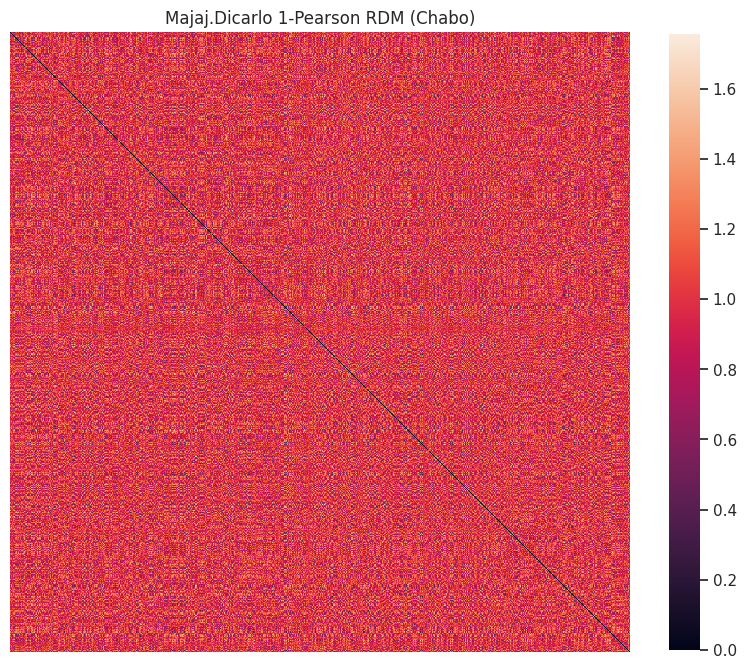

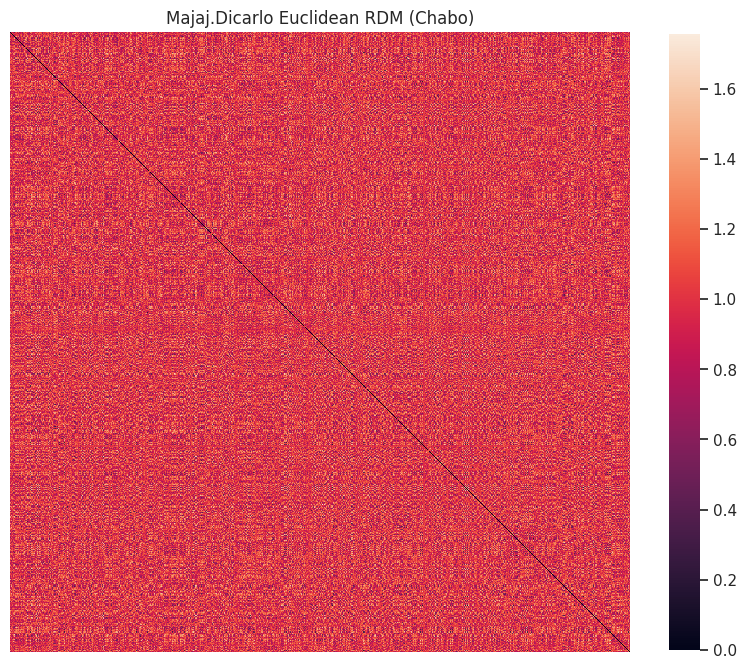

In [1]:
import xarray as xr
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns

majaj_data_path = '/data/shared/brainio/brain-score/assy_dicarlo_MajajHong2015_public.nc'
#'/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/assy_dicarlo_MajajHong2015_public/assy_dicarlo_MajajHong2015_public.nc'
def load_mjh_dataset(region, subject) -> xr.DataArray:
    da = xr.open_dataarray(majaj_data_path)
    da = da.where(da.animal.isin(subject),drop=True)
    da = da.where((da.region == region), drop=True)
    da = da.groupby('image_id').mean()
    da = da.squeeze(dim='time_bin', drop=True) #only keep for umap? (dim is size 1 anyway)
    return da.transpose()

subject = 'Chabo' #'Tito','Chabo'
data_tito = load_mjh_dataset(region='IT', subject='Tito')
data_chabo = load_mjh_dataset(region='IT', subject='Chabo')
#averaage?
data = data_tito

dvec_pearson = pdist(data, metric='correlation')
rdm_pearson = squareform(dvec_pearson)
dvec_euclidean = pdist(data, metric='euclidean')
rdm_euclidean = squareform(dvec_pearson)


sns.set(style = 'white', context='paper',
        rc={'axes.titlesize': 12,
            'lines.linewidth': 2.5,
            'axes.linewidth': 0.4})
sns.set(palette="colorblind")


fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(rdm_pearson, square=True, cbar_kws={"shrink": .8})
ax.set(title=f'Majaj.Dicarlo 1-Pearson RDM ({subject})')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(rdm_euclidean, square=True, cbar_kws={"shrink": .8})
ax.set(title=f'Majaj.Dicarlo Euclidean RDM ({subject})')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [5]:
import pandas as pd
path = '/data/shared/brainio/brain-score/dicarlo.hvm-public/image_dicarlo_hvm-public.csv'
majaj_csv = pd.read_csv(path)

FileNotFoundError: [Errno 2] No such file or directory: '/data/shared/brainio/brain-score/dicarlo.hvm-public/image_dicarlo_hvm-public.csv'

In [ ]:
#image paths used below
import os
import pandas as pd
import numpy as np
import xarray as xr
from PIL import Image

def paths_from_csv(image_dir, csv_path, column):
    file_names = pd.read_csv(csv_path)[column].values.tolist()
    image_paths = [os.path.join(image_dir, file) for file in file_names]
    return image_paths

def images_from_path(image_paths, return_da=True):
    images = np.stack(Image.open(i) for i in image_paths)
    if return_da:
        images = xr.DataArray(data=images)
    return images

majaj_dir = '/data/shared/brainio/brain-score/dicarlo.hvm-public'
majaj_csv = '/data/shared/brainio/brain-score/image_dicarlo_hvm-public.csv'
majaj_column = 'image_file_name'
majaj_image_paths = paths_from_csv(majaj_dir, majaj_csv, majaj_column)
majaj_images = images_from_path(majaj_image_paths)

In [ ]:
#load activations

from custom_model_tools.hooks import GlobalMaxPool2d,  RandomProjection
from model_tools.activations.pca import LayerPCA

from umap import UMAP
#from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

pooling =  'max'

#for layer in layers    
if pooling == 'max':
    handle = GlobalMaxPool2d.hook(self._extractor)
    #model.identifier?
elif pooling == 'none':
    handle = RandomProjection.hook(self._extractor)
    #model.identifier?
elif pooling == 'layerPCA':
    n_pcs = 1000
    handle = LayerPCA.hook(self._extractor, n_components=n_pcs)
    #model.identifier?
elif pooling == 'PCA_maxpool':
    handle = LayerPCA_Modified.hook(model, n_components=n_pcs, mod='max_pool')
    #model.identifier = model_identifier + f'|layer:{layer}|pooling:{pooling}|n_components:{n_pcs}'
elif pooling == 'PCA_zscore':
    handle = LayerPCA_Modified.hook(model, n_components=n_pcs, mod='z_score')
    #model.identifier = model_identifier + f'|layer:{layer}|pooling:{pooling}|n_components:{n_pcs}'

handles = []
if self._hooks is not None:
    handles = [cls.hook(self._extractor) for cls in self._hooks]
    
#image_paths = self.get_image_paths()
image_paths = majaj_image_paths
activations = self._extractor(image_paths, layers=[layer])
activations = activations.sel(layer=layer).values


umap = UMAP()
data_umap = umap.fit_transform(activations)
stimuli = majaj_images

fig, ax = plt.subplots(figsize=(20, 20))
for i_stimulus in range(len(stimuli)):
    image_box = OffsetImage(stimuli[i_stimulus].values, zoom=0.5)
    image_box.image.axes = ax

    ab = AnnotationBbox(
        image_box,
        xy=(data_umap[i_stimulus, 0], data_umap[i_stimulus, 1]),
        xycoords="data",
        frameon=False,
        pad=0,
    )
    ax.add_artist(ab)

ax.set_xlim([data_umap[:, 0].min(), data_umap[:, 0].max()])
ax.set_ylim([data_umap[:, 1].min(), data_umap[:, 1].max()])
ax.axis("off")

fig.suptitle("UMAP projection of model data")
fig.show()

#fig_path = '/home/wtownle1/dimensionality_powerlaw/figures/keaton'
#plt.savefig(f'{fig_path}/umap_test1.png')#, dpi=300)


In [ ]:
#UMAP example for parsing majaj activations (and images)

import os
import numpy as np
import pandas as pd
import xarray as xr
from PIL import Image
from umap import UMAP
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
)


#load activations...
data = load_activations()





majaj_stim_folder = '/data/shared/brainio/brain-score/dicarlo.hvm-public'
#majaj_stim_folder = '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public'
#rockfish csv: '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public/image_dicarlo_hvm-public.csv'
def get_mjh_image_paths():
    file_names = pd.read_csv('/data/shared/brainio/brain-score/image_dicarlo_hvm-public.csv')['image_file_name'].values.tolist()
    image_paths = [os.path.join(majaj_stim_folder,file) for file in file_names]
    return image_paths

def load_mjh_stimuli(image_paths):
    mjh_images = np.stack(Image.open(i) for i in image_paths)
    im_da = xr.DataArray(data=mjh_images)
    return im_da


mjh_im_paths = get_mjh_image_paths()
stimuli = load_mjh_stimuli(mjh_im_paths)

umap = UMAP()
data_umap = umap.fit_transform(data)

fig, ax = plt.subplots(figsize=(20, 20))

for i_stimulus in range(len(stimuli)):
    image_box = OffsetImage(stimuli[i_stimulus].values, zoom=0.5)
    image_box.image.axes = ax

    ab = AnnotationBbox(
        image_box,
        xy=(data_umap[i_stimulus, 0], data_umap[i_stimulus, 1]),
        xycoords="data",
        frameon=False,
        pad=0,
    )
    ax.add_artist(ab)

ax.set_xlim([data_umap[:, 0].min(), data_umap[:, 0].max()])
ax.set_ylim([data_umap[:, 1].min(), data_umap[:, 1].max()])
ax.axis("off")

fig.suptitle("UMAP projection of neural data")

fig_path = '/home/wtownle1/dimensionality_powerlaw/figures/keaton'
plt.savefig(f'{fig_path}/umap_test1.png')#, dpi=300)
#fig.show()

